In [1]:
import paho.mqtt.client as paho
import numpy as np
import random
import json
import networkx as nx
from node import EpidemicGraph, TransitionDiagram, calc_R0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
from IPython.display import clear_output
# %matplotlib inline

In [2]:
broker_ip = '192.168.0.104'
broker_ip = 'localhost'
# broker_ip = '10.1.199.251'
# broker_ip = '10.101.6.111'
broker_ip = '10.101.21.2'
connflag = False

In [3]:
def plot(G, title='step_1', ns=1000, fs=12, lim=2, figsize=(5, 5)):
    pos = nx.get_node_attributes(G, 'position')
    ids = {i:i for i in range(N)}
    print('Total node number', N)

    s_a = [x for x,y in G.nodes(data=True) if y['state']=='S_a']
    s_s = [x for x,y in G.nodes(data=True) if y['state']=='S_s']
    i1_a = [x for x,y in G.nodes(data=True) if y['state']=='I1_a']
    i1_s = [x for x,y in G.nodes(data=True) if y['state']=='I1_s']
    i2_a = [x for x,y in G.nodes(data=True) if y['state']=='I2_a']
    i2_s = [x for x,y in G.nodes(data=True) if y['state']=='I2_s']


    fig = plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_a, node_color='#66ff99')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_s, node_color='#006600')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_a, node_color='#ff6666')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_s, node_color='#cc0000')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_a, node_color='#3399ff')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_s, node_color='#0000cc')
    nx.draw_networkx_labels(G, pos, ids, font_size=fs)

    plt.title(title)
    red_patch = mpatches.Patch(color='red', label='I1')
    blue_patch = mpatches.Patch(color='blue', label='I2')
    green_patch = mpatches.Patch(color='green', label='S')
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    return plt, fig

In [4]:
mqttc = paho.Client()
counter = 0
N = 60
format_date = "%d %b %Y %H%M%S.%f"

def on_connect(client, userdata, flags, rc):
    global connflag
    #if connection is successful, rc value will be 0
    print("Connection returned result: " + str(rc) )
    connflag = True

def on_message(client, userdata, msg): 
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    
def on_state(client, userdata, msg): 
    global G, counter
    counter += 1
    name = datetime.now().strftime(format_date)
    js = json.loads(msg.payload.decode())
    G.node[js['pi_id']]['state'] = js['state']
#     if counter%N == 0:
#         plt, fig = plot(G, 'step {}'.format((counter-1)//N), **plt_set)
#         fig.savefig('figures/{}.png'.format(name))
#         plt.close()
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    print( log)
    with open("log.txt", "a") as myfile:
        myfile.write("{},{}\n".format(name, log))
        
def on_finish(client, userdata, msg):  # on finish step
    global node_set
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    with open("log_node_set.txt", "a") as myfile:
        myfile.write("{}\n".format(log))
    node_id = msg.payload.decode()
    node_set.remove(node_id)
    print(node_set)
#     with open("log_node_set.txt", "a") as myfile:
#         myfile.write("{},{}\n".format(node_set))
    if len(node_set) == 0:
        mqttc.publish('next', 'dummy_msg', qos=2)
        node_set = {str(x) for x in range(N)}
        clear_output(wait=True)
    
    
node_set = {str(x) for x in range(N)}
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.message_callback_add("state", on_state)
mqttc.message_callback_add("finish", on_finish)

mqttc.connect(broker_ip)
mqttc.loop_start()
mqttc.subscribe('state', 2)
mqttc.subscribe('finish', 2)

Connection returned result: 0

(0, 2)

(12.517073036216258, 12.517073036216258) (1, 0)
Total node number 60


/home/dd/.virtualenvs/pi/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


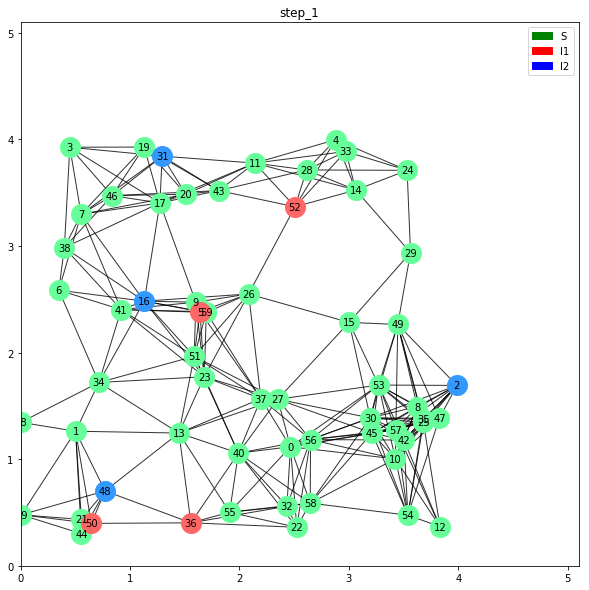

In [5]:
paramet = {
        'alpha': [0.5, 0.5], # infect rate 
        'mu': [0.5, 0.5], # sleep s 
        'gamma': [0.1, 0.1], # rec rate 
        'lambda': [0.7, 0.2], # sleep I1 
        'kappa': [0.7, 0.2] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
np.random.seed(315)  # structure
random.seed(6)       # infected
# N = 5
r = 1
number_subgraphs = 0

while number_subgraphs != 1:
    a = EpidemicGraph(N,r,paramet,I1_a=4, I2_a=4, grid_size=[4, 4], create=True) # net='Uniform Grid'
    number_subgraphs = len(list(nx.connected_component_subgraphs(a.G)))
    number_isolated_nodes = len(list(nx.isolates(a.G)))
    print(calc_R0(a.G, paramet), (number_subgraphs, number_isolated_nodes))

G = a.G
# G.node[0]['state'] = 'S_s'

plt_set = {
    'ns': 400, 
    'fs': 10,
    'lim': 5.1, 
    'figsize': (10,10)
}
plt, fig = plot(G, **plt_set) #  ns=300, fs=6,lim=5
# plt.show()
fig.savefig('figures/_.png')

In [6]:
G.node[1]

msg_list = []
for node_id in range(N):
    neighbours = list(G[node_id])
    msg = {
        "id": node_id,
        "state": G.node[node_id]['state'],
        "neighbours": neighbours
    }
    msg_list.append(msg)
    print(msg)
    
mqttc.publish('init', json.dumps(msg_list))

{'id': 0, 'state': 'S_a', 'neighbours': [10, 22, 27, 30, 32, 37, 40, 45, 53, 55, 56, 57, 58]}
{'id': 1, 'state': 'S_a', 'neighbours': [13, 18, 21, 34, 39, 44, 48, 50]}
{'id': 2, 'state': 'I2_a', 'neighbours': [8, 10, 25, 30, 35, 42, 45, 47, 49, 53, 57]}
{'id': 3, 'state': 'S_a', 'neighbours': [7, 17, 19, 31, 38, 46]}
{'id': 4, 'state': 'S_a', 'neighbours': [11, 14, 24, 28, 33, 52]}
{'id': 5, 'state': 'I1_a', 'neighbours': [9, 16, 23, 26, 37, 41, 51, 59]}
{'id': 6, 'state': 'S_a', 'neighbours': [7, 16, 34, 38, 41]}
{'id': 7, 'state': 'S_a', 'neighbours': [3, 6, 16, 17, 19, 20, 31, 38, 41, 46]}
{'id': 8, 'state': 'S_a', 'neighbours': [2, 10, 25, 30, 35, 42, 45, 47, 49, 53, 57]}
{'id': 9, 'state': 'S_a', 'neighbours': [5, 16, 17, 23, 26, 41, 51, 59]}
{'id': 10, 'state': 'S_a', 'neighbours': [0, 2, 8, 12, 25, 30, 35, 42, 45, 47, 53, 54, 56, 57, 58]}
{'id': 11, 'state': 'S_a', 'neighbours': [4, 14, 17, 20, 28, 31, 33, 43, 52]}
{'id': 12, 'state': 'S_a', 'neighbours': [10, 25, 42, 54, 57]}
{

In [ ]:
# node_set = {str(x) for x in range(5)}
# mqttc.publish('finish', '14', qos=2)
node_set


In [ ]:
mqttc.loop_stop()

In [ ]:
mqttc.publish('next', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('stop', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('kill', 'process die', qos=2)

In [ ]:
mqttc.publish('paramet', json.dumps(paramet), qos=2)

In [7]:
mqttc.publish('start', 'dummy_msg', qos=2)

-t state | -p {"step": 397, "pi_id": 16, "state": "I2_s"}
-t state | -p {"pi_id": 0, "state": "I2_s", "step": 397}
-t state | -p {"step": 397, "state": "I2_a", "pi_id": 50}
-t state | -p {"pi_id": 32, "state": "S_a", "step": 397}
-t state | -p {"step": 397, "pi_id": 17, "state": "I2_a"}
-t state | -p {"step": 397, "pi_id": 18, "state": "I2_a"}
-t state | -p {"step": 397, "pi_id": 19, "state": "I2_a"}
-t state | -p {"step": 397, "pi_id": 10, "state": "I2_a"}
-t state | -p {"step": 397, "pi_id": 11, "state": "I2_a"}
-t state | -p {"step": 397, "pi_id": 12, "state": "I2_a"}
-t state | -p {"step": 397, "pi_id": 13, "state": "I2_a"}
-t state | -p {"step": 397, "pi_id": 14, "state": "I2_a"}
-t state | -p {"step": 397, "pi_id": 15, "state": "I2_a"}
-t state | -p {"pi_id": 1, "state": "I2_s", "step": 397}
-t state | -p {"pi_id": 2, "state": "I2_a", "step": 397}
-t state | -p {"pi_id": 3, "state": "S_a", "step": 397}
-t state | -p {"pi_id": 4, "state": "I2_s", "step": 397}
-t state | -p {"pi_id

-t state | -p {"step": 397, "state": "S_a", "pi_id": 20}
-t state | -p {"step": 397, "state": "S_a", "pi_id": 21}
-t state | -p {"step": 397, "state": "I2_s", "pi_id": 22}
-t state | -p {"step": 397, "state": "S_a", "pi_id": 23}
-t state | -p {"step": 397, "state": "I2_a", "pi_id": 24}
-t state | -p {"step": 397, "state": "I2_a", "pi_id": 25}
-t state | -p {"step": 397, "state": "I2_s", "pi_id": 26}
-t state | -p {"step": 397, "state": "I2_a", "pi_id": 27}
-t state | -p {"step": 397, "state": "I2_a", "pi_id": 28}
-t state | -p {"step": 397, "state": "I2_a", "pi_id": 29}
{'21'}


In [ ]:
# mqttc.reinitialise()
# mqttc.loop_start()
msg = {
                'step': 22, 
                'pi_id': 27,  # 27
                'state': 'S_a'
            }
mqttc.publish('27', json.dumps(msg), 2) 

In [ ]:
# a = ['python node_{0}/pi_main_2.py node_{0}'.format(i) for i in range(0, 5)]
# str.join(' & ', a)

# with open('node_id.json') as f:
#     my_id_list = json.load(f)

# my_nodes = {node_id: node_id**2 for node_id in my_id_list}
node_list = list(range(5, 10))
node_list
